# Load

In [ ]:
import rdflib
import pandas as pd

g = rdflib.Graph()

# ... add some triples to g somehow ...
g.parse('F:/college materials/Mini/final.ttl',format='n3')
#g.parse('citation_ntriple.ttl',format='n3')

qres=g.query("""Select ?venue ?id ?references ?year where {
?dat det:venue ?venue  .
?dat det:year ?year .
?dat det:id ?id  .
?dat det:references ?references  .
}
""")
cnt=0
v=[]
ids=[]
ref=[]
y=[]

for row in qres:
    v.append(row[0])
    ids.append(row[1])
    ref.append(row[2])
    y.append(row[3])

df=pd.DataFrame()
df['Venue']=v
df['Year']=y
df['Id']=ids
df['References']=ref

In [ ]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.json("dblpref3.json");

print(df.collect())

df.head()
spark_df.toPandas()

In [6]:
print(len(df))
df=df[df['venue']!='IEEE Access']
df=df[df['venue']!='arXiv: Emerging Technologies']
print(len(df))
#list(df['venue'].unique())

79007
78298


# pull links

In [7]:
import re
import numpy as np

year=1990
linkslist=[]

while(year<2018):
    t=df[df['year']<=year]
    print('Length of',year,'data is',len(t))

    ftdic2={}
    #re.findall(r'\'([0-9a-z-]+)\'',t1['References'][0])
    for index,row in t.iterrows():
    
        if isinstance(row['references'],list):
            refs=row['references']
        else:
            refs=[]
            
        for i in refs:
            if ftdic2.get(i,0) ==0:
                ftdic2[i]=[]
                ftdic2[i].append(row['id'])
            else:
                ftdic2[i].append(row['id'])

    fromid2=[]
    toid2=[]
    for (i,j) in ftdic2.items():
        for ids in j:
            toid2.append(i)
            fromid2.append(ids)

    linksdf1=pd.DataFrame()
    linksdf1['From']=fromid2
    linksdf1['To']=toid2
    incid=[]
    t=linksdf1.copy()
    t.columns=['To','From']
    mdf=pd.merge(linksdf1,t,how='inner',left_on='From',right_on='From')

    incid=list(mdf['From'].unique())


    links=linksdf1[ (linksdf1['To'].isin(incid) | linksdf1['From'].isin(incid))]
    links=links.reset_index().drop(['index'],axis=1)
    print('Links length',len(links))
    linkslist.append(links)
    year+=1
    

Length of 1990 data is 627
Links length 3
Length of 1991 data is 785
Links length 25
Length of 1992 data is 876
Links length 38
Length of 1993 data is 992
Links length 38
Length of 1994 data is 1172
Links length 55
Length of 1995 data is 1318
Links length 76
Length of 1996 data is 1512
Links length 77
Length of 1997 data is 1758
Links length 88
Length of 1998 data is 1967
Links length 91
Length of 1999 data is 2226
Links length 113
Length of 2000 data is 2581
Links length 130
Length of 2001 data is 2966
Links length 130
Length of 2002 data is 3794
Links length 134
Length of 2003 data is 4537
Links length 191
Length of 2004 data is 5575
Links length 257
Length of 2005 data is 6473
Links length 335
Length of 2006 data is 8382
Links length 446
Length of 2007 data is 8881
Links length 482
Length of 2008 data is 9345
Links length 584
Length of 2009 data is 9864
Links length 681
Length of 2010 data is 10446
Links length 745
Length of 2011 data is 11021
Links length 805
Length of 2012 data is

# PageRank

In [8]:
pagerank_list=[]

for link_i in range(len(linkslist)) :
    unique_ids=list( set( list(linkslist[link_i]['From']) + list(linkslist[link_i]['To']) ) )
    page_rank=pd.DataFrame()
    page_rank['Paper Id']=pd.Series(unique_ids)
    page_rank['Old rank']=np.zeros(len(unique_ids))
    page_rank['New rank']=np.ones(len(unique_ids))


# Get latest page ranks for strongly connected component
    prev_ranks = dict()
    prev_ranks = dict(zip(page_rank['Paper Id'],page_rank['New rank']))

    many = 1

# Sanity check
    if len(prev_ranks) < 1 : 
        print("Nothing to page rank.  Check data.")

# Lets do Page Rank in memory so it is really fast
    myt=dict()
    for i in range(many):
        # print prev_ranks.items()[:5]
        next_ranks = dict();
        myt=prev_ranks
        total = 0.0
        total=sum(prev_ranks.values())
        next_ranks = dict( zip(page_rank['Paper Id'],np.zeros( len(page_rank['Paper Id']) ) ) )
        # print total
    
    
        # Find the number of outbound links and sent the page rank down each
        for (node, old_rank) in list(prev_ranks.items()):
            # print node, old_rank
            give_ids = list()
            temp_give=list(linkslist[link_i][linkslist[link_i]['From']==node]['To'].values)
            give_ids=temp_give
            #for ttid in temp_give:
                #if ttid in next_ranks.keys():
                    #give_ids.append(ttid)
        
            if ( len(give_ids) < 1 ) : continue
        
            amount = old_rank / len(give_ids)
        # print node, old_rank,amount, give_ids
    
            for id in give_ids:
                next_ranks[id] = next_ranks[id] + amount
    
        newtot = 0
        newtot=sum(next_ranks.values())
        evap = (total - newtot) / len(next_ranks)
    
    # print newtot, evap
        for node in next_ranks:
            next_ranks[node] = next_ranks[node] + evap
    
        newtot = 0
        newtot=sum(next_ranks.values())
        # Compute the per-page average change from old rank to new rank
        # As indication of convergence of the algorithm
        totdiff = 0
        for (node, old_rank) in list(prev_ranks.items()):
            new_rank = next_ranks[node]
            diff = abs(old_rank-new_rank)
            totdiff = totdiff + diff
    
        avediff = totdiff / len(prev_ranks)
        print(i+1, avediff)
        # rotate
        prev_ranks = next_ranks
    pagerank=pd.DataFrame()
    pagerank['Paper Id']=list(myt.keys())
    pagerank['Old rank']=list(myt.values())
    pagerank['New rank']=list(next_ranks.values())
    pagerank_list.append(pagerank)
    # Put the final ranks back into the database
    print(list(next_ranks.items())[:5])

    

1 0.25
[('96975e30-cb5c-499b-acad-4139df969cef', 1.0), ('2bd1873a-184f-49d6-a2e3-6456e178b442', 1.5), ('514567f3-be9c-42a7-adee-65adb6b1ecf5', 0.5), ('23e87727-a573-4cbc-ad44-179a13fcf1b1', 1.0)]
1 0.288888888889
[('b9bc2743-40fa-4031-99db-48d425b9982d', 0.66666666666666663), ('514567f3-be9c-42a7-adee-65adb6b1ecf5', 0.66666666666666663), ('067692a8-da25-4aab-844b-8c164ecdd3e1', 0.75757575757575757), ('96975e30-cb5c-499b-acad-4139df969cef', 1.1666666666666665), ('dad10223-c1b9-413a-9585-32a11674cc7f', 1.0)]
1 0.268595041322
[('7b926f2d-26d7-4129-a185-e963c67046f3', 0.81060606060606066), ('31ffc769-b3de-4691-83bb-ac980f118a82', 0.81060606060606066), ('b9bc2743-40fa-4031-99db-48d425b9982d', 0.72727272727272729), ('514567f3-be9c-42a7-adee-65adb6b1ecf5', 0.72727272727272729), ('067692a8-da25-4aab-844b-8c164ecdd3e1', 0.81818181818181823)]
1 0.268595041322
[('7b926f2d-26d7-4129-a185-e963c67046f3', 0.81060606060606066), ('31ffc769-b3de-4691-83bb-ac980f118a82', 0.81060606060606066), ('b9bc2743-

1 0.149830541554
[('81cda6f8-fe3a-4c9a-9c88-c68a2c4ea6d2', 0.95607808340727785), ('62bcd0cc-f981-4f3e-9a8e-aaadc01b1554', 0.91490161281904259), ('fc2384c8-1124-48ac-b4e9-fcb5715d3f45', 1.1405608420279676), ('ea1d1c7b-1e10-487f-b246-8f4d76045906', 0.91490161281904259), ('33e9cfdc-c769-43d3-9b9f-6a1cc22ecff5', 0.90870966235464623)]
1 0.129598314196
[('27f341d7-7e25-4dc9-aecc-c5f71fe517e5', 0.8770035802809143), ('b3e241a6-126f-40fb-a063-8ed7d0223a3c', 0.94367024694758095), ('f363592f-0812-4d9e-80b5-19e499905ca9', 0.88643754254506524), ('81cda6f8-fe3a-4c9a-9c88-c68a2c4ea6d2', 0.97700358028091427), ('cea2d33c-ba00-4c04-9fd8-5a0b175a5d72', 0.97700358028091427)]


# Clean up

In [9]:
pro_data=[]
for link_i in range(len(pagerank_list)):
    temp=pd.merge(df.set_index('id'),pagerank_list[link_i].set_index('Paper Id'),how='inner',left_index=True,right_index=True)
    temp.drop(['abstract','references','title'],axis=1,inplace=True)
    temp=temp[temp['venue'].str.len()>1]
    temp['author_count']=temp.apply(lambda x: len(x['authors']),axis=1)
    #temp['authors']=temp['authors'].astype(str)
    temp.reset_index(inplace=True)
    temp=temp.rename(index=str, columns={'index':'id'})
    pro_data.append(temp)
#temp[temp['New rank']==max(temp['New rank'])]


# add features

In [10]:
def cutauth(x,l):
    if len(x)>l : 
        return x[l]
    else : 
        return np.nan

for j in range(len(pro_data)):
    for l in range(3):
        st='author '+str(l)
        pro_data[j][st]=pro_data[j]['authors'].apply(cutauth,args=(l,))
pro_data[4].head()

,id,authors,venue,year,Old rank,New rank,author_count,author 0,author 1,author 2
0,514567f3-be9c-42a7-adee-65adb6b1ecf5,[Gary E. Kopec],"international conference on acoustics, speech,...",1984,1.0,0.737705,1,Gary E. Kopec,NaN,NaN
1,2bd1873a-184f-49d6-a2e3-6456e178b442,[Gary E. Kopec],"international conference on acoustics, speech,...",1983,1.0,1.737705,1,Gary E. Kopec,NaN,NaN
2,fef89403-e7f7-45fa-8da9-6375fc06dc5c,"[Mari Ostendorf, Salim Roukos]","IEEE Transactions on Acoustics, Speech, and Si...",1989,1.0,1.737705,2,Mari Ostendorf,Salim Roukos,NaN
3,27318145-8f25-4c7d-8dcb-c45cb7699bda,"[Joseph Polifroni, Stephanie Seneff, Victor W....",north american chapter of the association for ...,1991,1.0,0.737705,3,Joseph Polifroni,Stephanie Seneff,Victor W. Zue
4,8ee2a9c1-902b-4b9c-b42d-8e6ffd004057,"[Colin W. Wightman, N. M. Veilleuz, Mari Osten...",north american chapter of the association for ...,1991,1.0,0.737705,3,Colin W. Wightman,N. M. Veilleuz,Mari Ostendorf


In [29]:
#pro_data[1]['authors']=pro_data[1]['authors'].astype(str)
#pro_data[1][pro_data[1]['authors']==pro_data[1]['authors'][49]]
yc=1991

pro_data[0]['age']=pro_data[0].apply(lambda x: abs(x['year']-1990),axis=1)
pro_data[0]['pub_year']=pro_data[0].apply(lambda x: x['year'],axis=1)
pro_data[0]['year_data']=1990
final_data=pro_data[0]

for lnk_i in range(1,len(pro_data)):
    pro_data[lnk_i]['age']=pro_data[lnk_i].apply(lambda x: abs(x['year']-yc),axis=1)
    pro_data[lnk_i]['pub_year']=pro_data[lnk_i].apply(lambda x: x['year'],axis=1)
    pro_data[lnk_i]['year_data']=yc
    yc+=1
    final_data=final_data.append(pro_data[lnk_i], ignore_index=True)
len(final_data)
final_data.head()

,id,authors,venue,year,Old rank,New rank,author_count,author 0,author 1,author 2,age,pub_year,year_data
0,514567f3-be9c-42a7-adee-65adb6b1ecf5,[Gary E. Kopec],"international conference on acoustics, speech,...",1984,1.0,0.500000,1,Gary E. Kopec,NaN,NaN,6,1984,1990
1,2bd1873a-184f-49d6-a2e3-6456e178b442,[Gary E. Kopec],"international conference on acoustics, speech,...",1983,1.0,1.500000,1,Gary E. Kopec,NaN,NaN,7,1983,1990
2,514567f3-be9c-42a7-adee-65adb6b1ecf5,[Gary E. Kopec],"international conference on acoustics, speech,...",1984,1.0,0.666667,1,Gary E. Kopec,NaN,NaN,7,1984,1991
3,2bd1873a-184f-49d6-a2e3-6456e178b442,[Gary E. Kopec],"international conference on acoustics, speech,...",1983,1.0,1.666667,1,Gary E. Kopec,NaN,NaN,8,1983,1991
4,fef89403-e7f7-45fa-8da9-6375fc06dc5c,"[Mari Ostendorf, Salim Roukos]","IEEE Transactions on Acoustics, Speech, and Si...",1989,1.0,1.666667,2,Mari Ostendorf,Salim Roukos,NaN,2,1989,1991


# assign numeric values

In [30]:
final_data['id'] = final_data['id'].astype('category')
final_data['authors']=final_data['authors'].astype(str)
final_data['venue'] = final_data['venue'].astype('category')
final_data['authors'] = final_data['authors'].astype('category')
final_data['author 0'] = final_data['author 0'].astype('category')
final_data['author 1'] = final_data['author 1'].astype('category')
final_data['author 2'] = final_data['author 2'].astype('category')
remapv=dict( enumerate(final_data['venue'].cat.categories) )
cat_columns =final_data.select_dtypes(['category']).columns
final_data[cat_columns] = final_data[cat_columns].apply(lambda x: x.cat.codes)
#final_data.drop('authors',inplace=True,axis=1)
final_data.head()

,id,authors,venue,year,Old rank,New rank,author_count,author 0,author 1,author 2,age,pub_year,year_data
0,1091,920,550,1984,1.0,0.500000,1,827,-1,-1,6,1984,1990
1,562,920,550,1983,1.0,1.500000,1,827,-1,-1,7,1983,1990
2,1091,920,550,1984,1.0,0.666667,1,827,-1,-1,7,1984,1991
3,562,920,550,1983,1.0,1.666667,1,827,-1,-1,8,1983,1991
4,3494,1728,169,1989,1.0,1.666667,2,1556,2168,-1,2,1989,1991


# Test & train

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split

features=final_data.copy()
features.drop('pub_year',axis=1,inplace=True)
features.drop('year',axis=1,inplace=True)

features.drop(['Old rank'],axis=1,inplace=True)
labels = features['New rank']
features= features.drop('New rank',axis=1)
feature_list = list(features.columns)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.0, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
features.head()

Training Features Shape: (5297, 9)
Training Labels Shape: (5297,)
Testing Features Shape: (0, 9)
Testing Labels Shape: (0,)


,id,authors,venue,author_count,author 0,author 1,author 2,age,year_data
0,1091,920,550,1,827,-1,-1,6,1990
1,562,920,550,1,827,-1,-1,7,1990
2,1091,920,550,1,827,-1,-1,7,1991
3,562,920,550,1,827,-1,-1,8,1991
4,3494,1728,169,2,1556,2168,-1,2,1991


# GBRT

In [32]:
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators': 3500, 'max_depth': 6,'learning_rate': 0.01, 'loss': 'lad'}

clf = GradientBoostingRegressor(**params).fit(train_features,train_labels)

#pre=clf.predict(test_features)
#print(pre)
#errors = abs( clf.predict(test) - test)
#mape = 100 * (errors / test)
# Calculate and display accuracy
#accuracy = 100 - np.mean(mape)
#print('Accuracy:', round(accuracy, 2), '%.')

In [16]:
#final_data['id']=final_data['id'].astype('category')
#final_data['id']=final_data['id'].cat.codes
#print(list(zip(final_data['id'].cat.codes,final_data['id'].cat.categories)))
errors = abs( pre - test_labels)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

NameError: name 'pre' is not defined

# Fast Run

In [197]:
clf=pickle.load(open('gba_predict', 'rb'))
future_test = pd.read_pickle('test_feature_with_rank')
remapv=pickle.load(open('remap venue', 'rb'))

In [198]:
xy=2029
#future_test=train_features.copy() -----------------remove comment if not fast run
#future_test['rank']=list(train_labels) -----------------remove comment if not fast run


#uq=list(future_test['id'].unique()) -----------------remove comment if not fast run
#future_test=future_test[ (future_test['id'].isin(uq)) & (future_test['year_data']==2017) ]  -----------------remove comment if not fast run
#future_test.to_pickle('test_feature_with_rank')

#future_test = pd.read_pickle('test_feature_with_rank')
old_rank=list(future_test['rank'])
future_test.drop('rank',axis=1,inplace=True)
#df.to_pickle('all_data')


#df = pd.read_pickle('all_data')

future_test['year_data']=xy
future_test['age']+=(xy-2017)

#rf=pickle.load(open('rf_predict', 'rb'))
#print(len(future_test))
future_test.head()
#future_test.count()'''

,id,authors,venue,author_count,author 0,author 1,author 2,age,year_data
4140,98,489,582,4,440,194,386,13,2029
5184,2116,1131,435,7,1018,2317,861,12,2029
4656,367,119,496,2,108,2101,-1,12,2029
5252,383,2423,603,4,2181,2145,681,20,2029
4055,1886,360,377,4,323,2282,2191,12,2029


In [199]:
from heapq import nlargest

#remid=pickle.load(open('re_map_id', 'rb'))
fin=future_test.copy()
fin['new rank']=clf.predict(future_test)
fin['old rank']=old_rank
#fin['diff']=fin['new rank']-fin['old rank']
fin.head()

,id,authors,venue,author_count,author 0,author 1,author 2,age,year_data,new rank,old rank
4140,98,489,582,4,440,194,386,13,2029,2.260143,1.877004
5184,2116,1131,435,7,1018,2317,861,12,2029,1.842627,0.877004
4656,367,119,496,2,108,2101,-1,12,2029,2.057778,1.877004
5252,383,2423,603,4,2181,2145,681,20,2029,1.860260,1.877004
4055,1886,360,377,4,323,2282,2191,12,2029,1.826139,0.877004


In [200]:
fin=fin.groupby('venue').agg({'new rank':np.sum,'old rank':np.sum})
fin=fin.reset_index()
fin['diff']=fin['new rank']-fin['old rank']
fin=fin.nlargest(10,'diff')
fin.head()

,venue,new rank,old rank,diff
423,423,230.190376,166.267335,63.923041
528,528,194.592940,136.463044,58.129897
369,369,147.914897,96.360286,51.554610
418,418,103.830821,68.904894,34.925927
336,336,126.039817,93.224890,32.814927


In [201]:

#pd.Series(remid).iloc[1200]
idli={}
for i in fin['venue']:
    idli[remapv[i]]=fin['diff'][fin['venue']==i].values[0]

#top=df[df['venue'].isin(idli.keys())]
#top=top.drop_duplicates(subset='venue', keep='first')
#top.drop(['abstract','references','title'],axis=1,inplace=True)
#top['diff']=top['venue'].map(idli)
#print(list(top['venue']),list(top['rank']))
#trends=list(top['venue'])
#tranks=list(top['diff'])
trends=list(idli.keys())
tranks=list(idli.values())


for i in range(len(trends)):
    query=trends[i]
    stopwords = ['conference','international','arxiv:','global','on','journal','of','of','the','european','symposium','IEEE','research']
    querywords = query.split()

    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    trends[i] = ' '.join(resultwords)
    
print(list(zip(trends,tranks)))
#print(top['title'])
#top

[('Computer Vision and Pattern Recognition', 63.923040706036289), ('human factors in computing systems', 58.129896624196192), ('Sensors', 51.554610368069504), ('Computation and Language', 34.925927339287682), ('Neurocomputing', 32.814927384629584), ('Learning', 30.958911685089348), ('Information Theory', 30.19182785837306), ('communications', 25.813551383007535), ('pattern recognition', 23.14119786358367), ('management data', 23.059627015890882)]


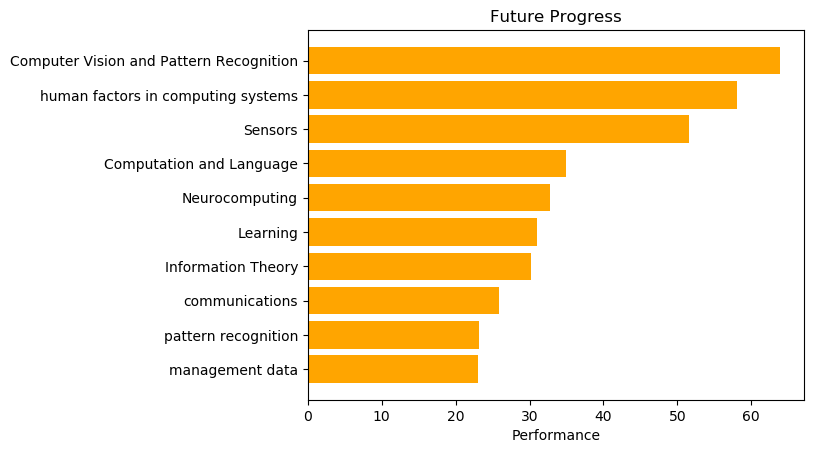

In [202]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = trends
y_pos = np.arange(len(trends))
performance = tranks

ax.barh(y_pos, performance, align='center',
        color='orange', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Future Progress')

plt.show()

# Pickle needed data 

In [177]:
import pickle
df[df['venue']=='human factors in computing systems']
pickle.dump(clf, open('gba_predict', 'wb'))
pickle.dump(remapv, open('remap venue', 'wb'))
future_test.to_pickle('test_feature_with_rank')

In [204]:
df[df['venue']=='Neurocomputing']

,abstract,authors,id,references,title,venue,year
39,This paper addresses the synchronization and s...,"[R. Sakthivel, M. Sathishkumar, B. Kaviarasan,...",08ed3a9e-75a9-4f91-b318-c24cf56eb6e7,"[13a1ecb2-e3c6-40f0-b7a7-a1fe8390e0a3, 1454d5f...",Synchronization and state estimation for stoch...,Neurocomputing,2017
283,NaN,"[F. Sandoval, Alberto Prieto, Miguel Atencia]",4459ede1-9770-42ce-8f83-cf8917690a9f,"[0ae9e93f-8ac4-41d8-9bd7-462edcf04af1, 3767130...",New trends in computational intelligence,Neurocomputing,2017
527,Fault diagnosis for aircraft fuel system can n...,"[Z.Z. Gao, Cunbao Ma, Dong Song, Yang Liu]",88abe9e7-5523-40a3-979b-cb19142adfd1,"[06700b8d-fd6f-47f2-ad1c-d40a0b6bbd25, 0a03913...",Deep quantum inspired neural network with appl...,Neurocomputing,2017
822,"In practical object recognition tasks, one oft...","[Xiao Li, Min Fang, Jinqiao Wu]",d2cc109d-db83-4944-abd4-f71580fe4eb0,"[096848ae-c9a9-4de9-ab0e-e2af50837601, 096b231...",Zero-shot classification by transferring knowl...,Neurocomputing,2017
1088,Face sketch synthesis refers to the technique ...,"[Nannan Wang, Mingrui Zhu, Jie Li, Bin Song, Z...",1557d3ef-785a-42d5-8ddf-6d6daeb70d8a,"[11dfdff9-7680-489f-a30f-96198eccff31, 23b2263...",Data-driven vs. model-driven: Fast face sketch...,Neurocomputing,2017
2122,This paper investigates the problem of stabili...,"[Liming Ding, Yong He, Yiwei Liao, Min Wu]",23764d55-ba27-44ae-94a3-a23c61598b62,"[02c09b3a-b467-4912-9074-b3ed6efdd349, 04114da...",New result for generalized neural networks wit...,Neurocomputing,2017
3643,Paper cooperation network embodies expert topi...,"[Shengxiang Gao, Xian Li, Zhengtao Yu, Yu Qin,...",a7223856-24d4-4a27-97e0-f64b94c1a632,"[0840a94d-6566-43b2-9df4-b21a1c7b9a15, 0ad38f3...",Combining paper cooperative network and topic ...,Neurocomputing,2017
3732,Previous studies have demonstrated that matrix...,"[Xue Li, Xiaobo Shen, Zhenqiu Shu, Qiaolin Ye,...",bbb3c3b4-5588-415a-967f-da79ee5f558b,"[04bf14c3-fc94-4321-9efe-55654a47910c, 05bbaec...",Graph regularized multilayer concept factoriza...,Neurocomputing,2017
4360,3D face reconstruction from a 2D face image ha...,"[Jian Zhang, Ke Li, Yun Liang, Na Li]",63727ea9-73a2-46a7-a567-d7d44a9a82a8,"[11dfdff9-7680-489f-a30f-96198eccff31, 1230a85...",Learning 3D faces from 2D images via Stacked C...,Neurocomputing,2017
4998,Neuro-fuzzy systems are known for their abilit...,[Krzysztof Simiński],ff34a1c3-5448-4273-92f0-04d98b96fcd5,"[07fa39d8-6db7-4708-9ae3-05567f1e121b, 0980245...",Robust subspace neuro-fuzzy system with data o...,Neurocomputing,2017
